# CF preprocessing with new modules
In this notebook I use participant class to get my data preprocessed and then I use the visual space and limit vertices functionality I added to prfpy for CF analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import numpy as np
import preprocess
import cortex as cx
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation

/tank/klundert/.local/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [26]:
import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]



roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


ind = np.array(list(roi_index_dict.values()))[12:]
boolmask = atlas_data_both_hemis == roi_index_dict['V1']
for i, ROIs in enumerate(ind):
  boolmask = np.array(atlas_data_both_hemis == ind[i]) + boolmask
  print(ROIs)

4
5
13
19
17
48
95
49
10
2
23
20
21
159


### preprocessing

In [31]:
subject = 'sub-02'
deriv_dir = '/scratch/2021/nprf_ss/derivatives/'
scalar_dir = '/tank/klundert/projects/means/'
sbj = preprocess.participant(subject, deriv_dir, scalar_dir)

In [ ]:
# would run the following if scalars are not already created
# sub.get_scalars()

In [32]:
# get the half-half split data (even and uneven runs)
sbj.get_folds(remove_edge=True)

/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:177: RuntimeWarning: Mean of empty slice
  self.data_train = np.nanmean(np.array(data[::2]), axis=0)
/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:178: RuntimeWarning: Mean of empty slice
  self.data_test = np.nanmean(np.array(data[1::2]), axis=0)


In [11]:
# load design matrix of pRF experiment. We use this to determine max eccentricity

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

print(max_ecc_size)

8.91243496952274


### CF analysis

In [13]:
sub = 2
fold = 1

roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = 0.4)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/downloads/prfpy/prfpy/utils.py:221: RuntimeWarning: divide by zero encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances
/tank/klundert/downloads/prfpy/prfpy/utils.py:221: RuntimeWarning: invalid value encountered in true_divide
  CMF_matrix = self.distance_matrix/visual_distances


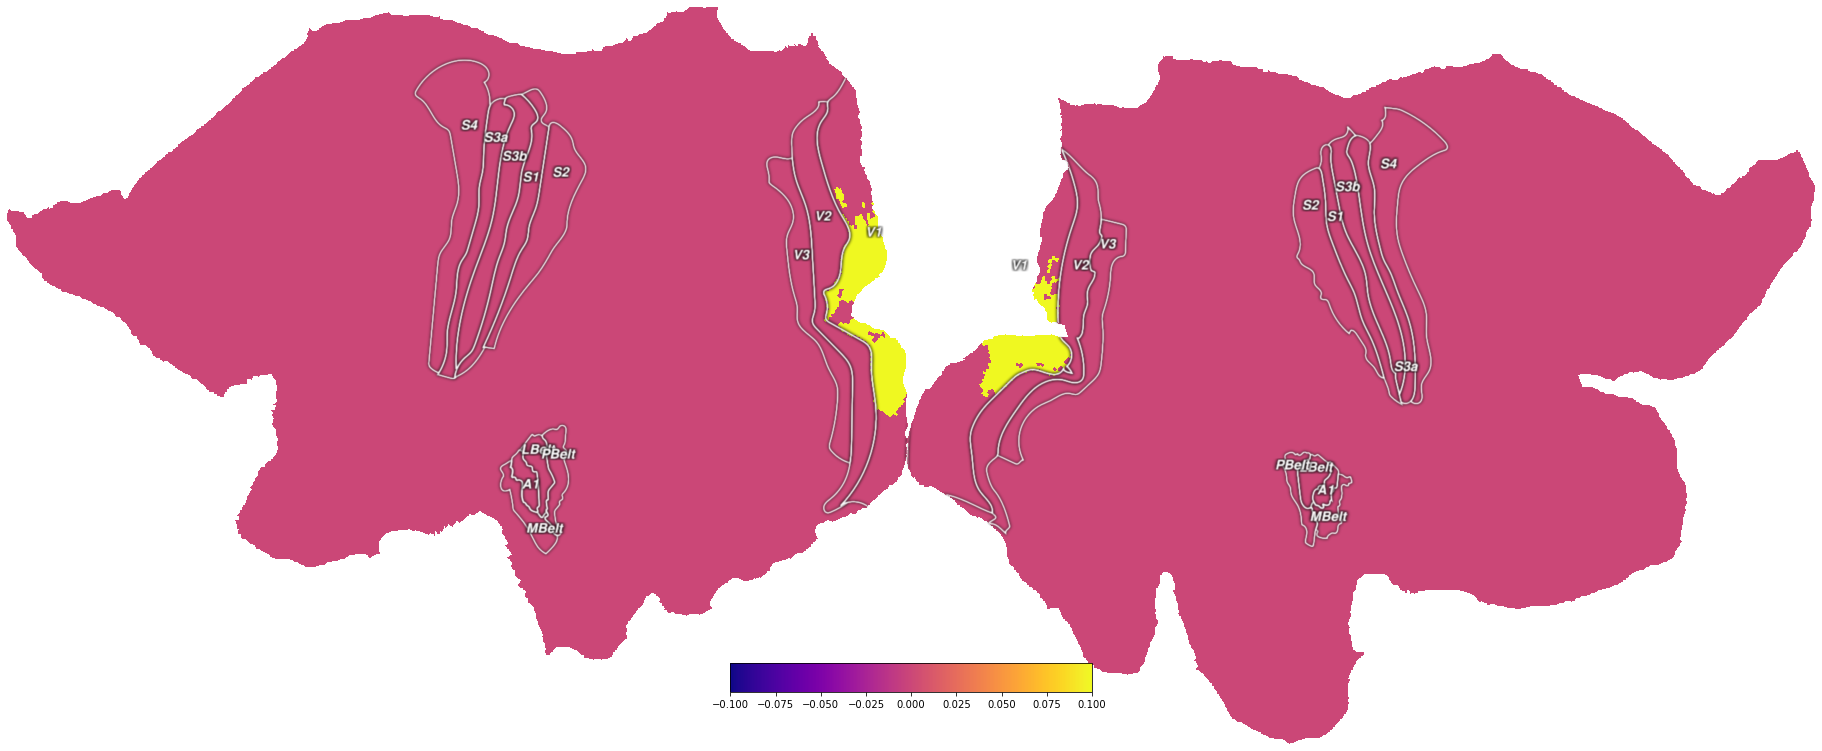

In [14]:
# myv1surf.intmask is a binary mask that shows which vertices we use for CF sampling
cx.quickshow(cx.Vertex(myv1surf.intmask, subject='hcp_999999', cmap='plasma'), with_curvature=True);


In [33]:
# get the data in format for CF analysis
mydat_train = np.nan_to_num(get_cortex(sbj.data_train)[:,10:])
mydat_test = np.nan_to_num(get_cortex(sbj.data_test)[:,10:])

# create stimuli objects
train_stim=CFStimulus(mydat_train, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)
test_stim=CFStimulus(mydat_test, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)

# get data in format for CF analysis, but now only a portion of the cortex for faster
# analysis. You have to do this after creating the stimuli objects.
mydat_train = np.nan_to_num(get_cortex(sbj.data_train)[:,10:])[boolmask]
mydat_test = np.nan_to_num(get_cortex(sbj.data_test)[:,10:])[boolmask]



{'subject': 'sub-02',
 'derivatives_dir': '/scratch/2021/nprf_ss/derivatives/',
 'scalar_dir': '/tank/klundert/projects/means/',
 'prep_dir': '/scratch/2021/nprf_ss/derivatives/fmriprep/sub-02',
 'preproc_dir': '/scratch/2021/nprf_ss/derivatives/pybest/sub-02',
 'sessions': ['ses-01', 'ses-02', 'ses-03', 'ses-04']}

In [34]:
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40,60,80,110])

# Define the fitter
gf_vis = CFFitter(data=mydat_train,model=model)
gf_vis.n_jobs = 25
# Perform the fitting.
gf_vis.grid_fit(sigmas, verbose=True, n_batches=60)

Each batch contains approx. 182 voxels.


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  60 out of  60 | elapsed:   11.0s finished


In [41]:
CF_bounds = [(0.1, 150),  # sigmas
                (0, 1000),  # beta
                (0, 0.0001), # baseline
                (0, 0)] # vert

CF_bounds = np.array(CF_bounds)
CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
CF_bounds[:,3,0] = gf_vis.vertex_centres
CF_bounds[:,3,1] = gf_vis.vertex_centres

gf_vis.iterative_fit(rsq_threshold=-1, verbose=True, constraints=[], starting_params=gf_vis.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

# get model predictions
fit_stimulus = np.copy(gf_vis.model.stimulus)
gf_vis.model.stimulus = test_stim

sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf_vis.iterative_search_params.T)
model_tc_vis = np.zeros(mydat_train.shape)
i = 0
for i in range(np.size(vert_centrei)):
    model_tc_vis[i,:] = gf_vis.model.return_prediction(sigmasi[i], betai[i], baselinei[i], vert_centre[i])

gf_vis.model.stimulus = train_stim

# crossvalidate rsq
CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc_vis)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
CV_rsq[CV_rsq <= -1] = np.nan
CV_rsq[CV_rsq >= 1] = np.nan

gf_vis.iterative_search_params[:,-1] = CV_rsq
gf_vis.iterative_search_params[:,3] = vert_centre

np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_LOGvisual_space_fold{fold}_zsc.npy', gf_vis.iterative_search_params)



DNCF_bounds = [(0.1, 150),  # sigmas
            (0, 1000),  # prf amplitude
            (0, 0.0001), # baseline (A)
            (0, 0), # vert
            (0, 1000), # srf amplitude (C)
            (0.3, 100), # surround sigma 
            (0, 1000), # neural baseline (B)
            (1e-6, 1000)] # surround baseline (D)


DNCF_bounds = np.array(DNCF_bounds)
DNCF_bounds = np.repeat(DNCF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
DNCF_bounds[:,3,0] = gf_vis.vertex_centres
DNCF_bounds[:,3,1] = gf_vis.vertex_centres

# set constraint for surround>centre sigma
constraints_gauss, constraints_css, constraints_dog, constraints_norm = [],[],[],[]
A_ssc_norm = np.array([[-1,0,0,0,0,1,0,0]])  
constraints_norm.append(LinearConstraint(A_ssc_norm,
                                            lb=0,
                                            ub=+np.inf))

gfdn = Norm_CFGaussianModel(train_stim)

fitdn = Norm_CFGaussianFitter(data=mydat_train,
                                   model=gfdn,
                                   n_jobs=40,
                                   previous_gaussian_fitter=gf_vis)

fitdn.iterative_fit(rsq_threshold=-1, verbose=True, constraints=constraints_norm, starting_params=gf_vis.iterative_search_params, bounds=DNCF_bounds, ftol=1e-7, xtol=1e-7)

sig, pamp, boldb, verti, srfamp, srfsig, neurb, surrb, Rsq = fitdn.iterative_search_params.T

fit_stimulus = np.copy(fitdn.model.stimulus)
fitdn.model.stimulus = test_stim

dncf_tc = np.zeros(mydat_test.shape)
i = 0
for i in range(np.size(vert_centrei)):
    dncf_tc[i,:] = fitdn.model.return_prediction(sig[i], pamp[i], boldb[i], vert_centre[i], srfamp[i], srfsig[i], neurb[i], surrb[i])

fitdn.model.stimulus = train_stim

CVdncf_rsq = np.nan_to_num(1-np.sum((mydat_test-dncf_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))

CVdncf_rsq[CVdncf_rsq <= -1] = np.nan
CVdncf_rsq[CVdncf_rsq >= 1] = np.nan

fitdn.iterative_search_params[:,-1] = CVdncf_rsq
fitdn.iterative_search_params[:,3] = vert_centre

np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_norm_CF_params_LOGvisual_space_fold{fold}_zsc.npy', fitdn.iterative_search_params)

array([ 45371.,  45294., 101375., ...,  45438.,  45438.,  45367.])